<center>
<img src="logo.png" height="900"> 
</center>


# Arriva, ой то есть ARIMA

Все хотят знать, что же будет дальше с экономикой. Из-за этого люди активно придумывают и строят всякие индикаторы, которые должны помочь понять, когда начнётся кризис. В этом задании вам предстоит проанализировать несколько подобных индикаторов и выяснить правда ли они улучшают прогнозы. 

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns

from matplotlib import pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

# 1. Краткая история

__Про ручные индексы__

Экономисты хотят понимать насколько сильно люди верят в прекрасное экономическое будущее. Для этого они проводят социальные опросы: просят оценить насколько люди доверяют банкам, спрашивают есть ли у них инвестиции в ценные бумаги и тп. В итоге ответы на эти вопросы превращаются в индекс потребительских настроений. 

Первым такую штуку начал делать Мичиганский университет. Он спрашивает $500$ потребителей. Каждому задаёт $5$ вопросов, касающихся их финансового положения и мнения о нынешнем состоянии (2 вопроса) и будущем (3 вопроса) экономики. Берется процентная доля респондентов, отметивших улучшение экономических условий, из нее вычитается доля тех, кто заявил, что стало хуже, к полученному числу прибавляется 100. Из ответов на первые 2 вопроса формируется обзор нынешнего экономического положения, из последних $3$-х — индекс потребительских ожиданий. Таким образом, ожидания отвечают примерно за $60\%$ индекса. Расчёт индекса делается дважды в месяц.

В России по аналогичной методике "Левада-центр" начал считать свой индекс потребительских натсроений. На его динамику даже можно посмотреть [у них на сайте.](https://www.levada.ru/indikatory/sotsialno-ekonomicheskie-indikatory/) На самом деле, сейчас социологи считают довольно много подобных индексов. Тот же самый [PMI (индекс деловой активности)](https://ru.wikipedia.org/wiki/Индекс_деловой_активности) - один из возможных вариантов. 

Такие индексы можно пытаться использовать для того, чтобы улучшить прогнозы разных макроэкономических рядов вроде безработицы. И люди активно пытаются это делать. Проблема заключается в том, что нужно тратить много ресурсов на то, чтобы сделать социальный опрос. Плюс социальные опросы можно делать редко. Хочется, чтобы было быстро, дёшево и часто.

__Про автоматические индексы__

Выход есть. Нужно заглянуть в интернет. Любая поисковая система собирает статистику, связанную с запросами пользователей. Более того, частично такая статистика [находится в открытом доступе.](https://trends.google.ru/trends/?geo=RU) Это позволяет собирать информацию о том, чем интересовались люди и на её основе делать какие-то выводы.

Например, в 2013 году Google заявил, что с помощью информации из поисковых запросов о трейлерах, он может с низкой MAPE предсказывать кассовость ленты в первые дни показа. Поисковые запросы используют для предсказания распространения эпидемий гриппа и даже ковида.

По аналогии можно узнать, чем люди интересуются во время кризиса, а дальше попытаться отслеживать такие запросы и понимать, насколько сильно колеблется их обеспокоенность. 

# 2. Данные 

В табличке ниже вам даны несколько индексов потребительских настроений и несколько переменных для прогнозирования: 

- `levada_IPN` - индекс потребительских настроений, который строится на основе социальных опросов Левада-центром. Отражает то, насколько сильно люди доверяют экономике.
- `poiskInd_corr`- индекс поиска, отражает то, насколько сильно люди обеспокоенны тем, что происходит с экономикой. Он построен на основе поисковых запросов. Как именно - для задания неважно, но подробнее об этом можно почитать [в статье про подобные индексы.](https://rjmf.econs.online/2020/4/forecasting-macroeconomic-indicators-news-and-search-queries/)

- `USD` - динамика курса доллара
- `RTRD` - оборот розничной торговли (текущие цены, млрд. рублей)

In [2]:
df = pd.read_csv('data.tsv', sep='\t')
df.set_index('fielddate', inplace=True)
print(df.shape)
df.head()

(194, 4)


,poiskInd_corr,RTRD,levada_IPN,USD
fielddate,,,,
2004-01-01,3.455561,396.5,NaN,28.838795
2004-02-01,9.761241,397.4,NaN,28.514674
2004-03-01,16.271264,433.6,NaN,28.529262
2004-04-01,18.356332,435.6,NaN,28.685632
2004-05-01,10.663158,435.7,NaN,28.989217


выбросим все стоки с пропусками и будем рассматривать индексы на одном и том же временном промежутке. 

In [3]:
df.dropna(inplace=True)

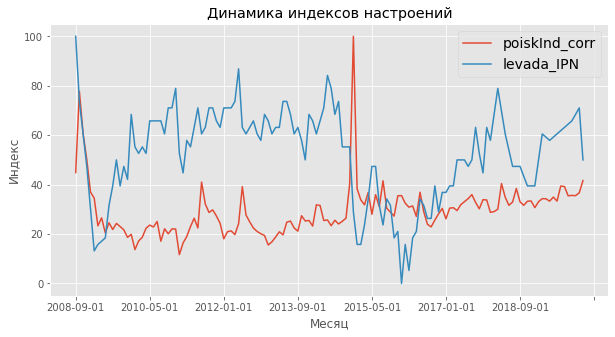

In [4]:
df[['poiskInd_corr', 'levada_IPN']].plot(figsize=(10,5));

plt.title('Динамика индексов настроений');
plt.xlabel("Месяц")
plt.ylabel("Индекс")
plt.legend(fontsize=14);

Видно, что в период кризиса индекс доверия Левады падает. Индекс обеспокоенности, построенный по гуглу, растёт. 

# 3. Предварительный анализ рядов

Проанализируем динамику валютного курса и оборота розничной торговли более детально.

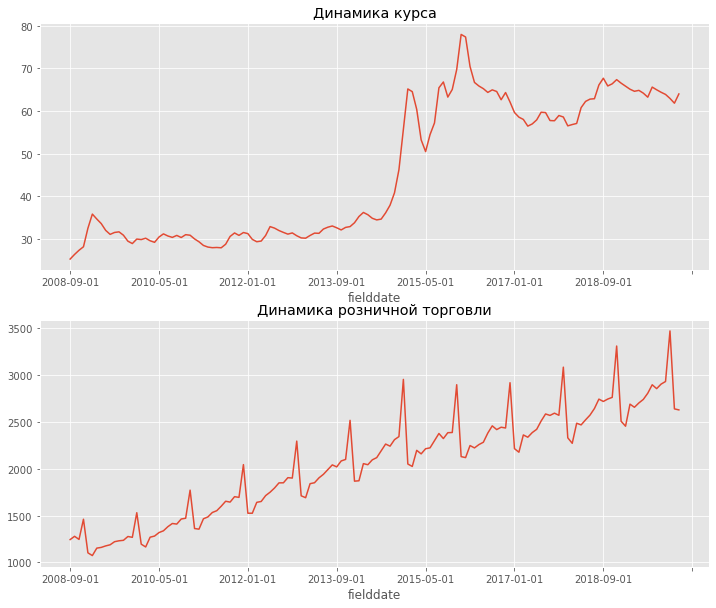

In [5]:
_, axes = plt.subplots(2, 1, figsize=(12,10))

df['USD'].plot(ax=axes[0]);
df['RTRD'].plot(ax=axes[1]);

axes[0].set_title("Динамика курса")
axes[1].set_title("Динамика розничной торговли");

- Видим, что динамика валютного курса нестационарна. У нас есть два математических ожидания. В динамике ряда нет ни тренда ни сезонности.
- В динамике розничной торговли есть тренд и сезонность.  

__[а] Проверьте гипотезу о стационарности рядов с помощью KPSS и ADF тестов на уровне значимости $5\%$. В качестве ответа в переменнык `pval` запишите соотвествующие p-value.__ Обратите внимание, что в динамике розничной торговли есть константа и тренд. В динамике курса есть константа.

In [15]:
from statsmodels.tsa.stattools import adfuller, kpss

### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

pval_usd_kpss = kpss(df['USD'], regression='c')[1]
pval_rtrd_kpss = kpss(df['RTRD'], regression='ct')[1]

pval_usd_adf = adfuller(df['USD'], regression='c')[1]
pval_rtrd_adf = adfuller(df['RTRD'], regression='ct')[1]


# your code here


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


In [16]:
assert np.abs(pval_usd_kpss - 0.01) < 1e-2
assert np.abs(pval_usd_adf - 0.77) < 1e-2

# несколько похожих скрытых тестов

Оба ряда оказались на уровне значимости $5\%$ нестационарными по всем тестам. 

__[б]__ Возьмите первую разность от валютного курса методом `.diff()`. Для оборота розничной торговли возьмите $12$-ую, сезонную разность. Изобразите динамику разностей на картике. 

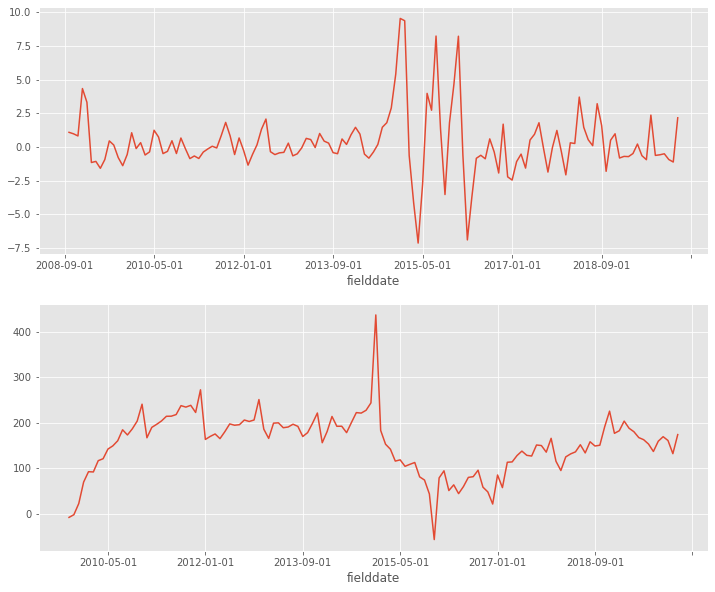

In [22]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you
usd_diff = df['USD'].diff()
rtrd_diff = df['RTRD'].diff(12)

fig, ax = plt.subplots(2, 1, figsize=(12, 10))
usd_diff.plot(ax=ax[0])
rtrd_diff.plot(ax=ax[1])
# your code here


Проверьте ADF-тестом гипотезу о стационарности рядов на уровне значимости $5\%$. В соотвествующие переменные запишите `pvalue` тестов. Обратите внимание, что для курса у нас нет ни константы, ни тренда. Для оборота торговли есть константа.

In [24]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

pval_diff_usd = adfuller(usd_diff.dropna(), regression='nc')[1]
pval_diff_rtrd = adfuller(rtrd_diff.dropna(), regression='c')[1]


# your code here


In [26]:
pval_diff_usd, pval_diff_rtrd

(1.650774482648531e-14, 0.03684914819183377)

In [25]:
assert pval_diff_usd < 1e-10

# несколько похожих скрытых тестов

Для обоих рядов гипотеза о наличии единичного корня отвергается. 

> Посмотрим внимательнее на динамику разностей валютного курса. Возникает ощущение, что в конце $2014$ - $2015$ годах дисперися валютного курса была больше, чем в другие периоды времени. Это связано с [валютным кризисом](https://ru.wikipedia.org/wiki/Валютный_кризис_в_России_(2014—2015)) и тем, что с этого момента ЦБ сфокусировался на таргетировании инфляции. Такой разброс в дисперсии будет приводить к тому, что предпосылки ARIMA-модели не будут выполняться. Из-за этого будут портиться доверительные интервалы. Можно стабилизировать дисперсию преобразованием Бокса-Кокса.

__[в]__ Обучите на исходном ряде для курса преобразование Бокса-Кокса, если подзабыли что это за преобразование, пересмотрите лекцию про это из самого первого курса :) Возьмите первые разности, нарисуйте ряд на картинке, стала ли ситуация с дисперсией визуально лучше?

In [28]:
from pmdarima.preprocessing import BoxCoxEndogTransformer

### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

transformer = BoxCoxEndogTransformer()
transformer.fit(df['USD'])

# your code here


BoxCoxEndogTransformer(floor=1e-16, lmbda=None, lmbda2=0, neg_action='raise')

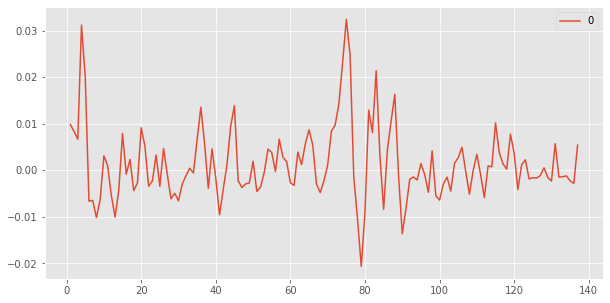

In [36]:
pd.DataFrame(transformer.transform(df['USD'])[0]).diff().plot(figsize=(10, 5))

In [29]:
assert np.abs(transformer.lam1_ + 0.447) < 1e-3

# Тут нет скрытых тестов :)

# 4. ARIMA-модель

Разобьём выборку на тренировочную и тестовую, а затем обучим ARIMA-модель. 

1. Параметры `p,q` перебирайте от 0 до 5 включительно, `P,Q` от 1 до 3
2. Параметр `seasonal` выставите в `true` с `m=12`
3. Параметры `max_D, max_d` потавьте равными 2
4. Парааметр `max_order` выставите в 10
5. В поле `information_criterion` выберите для выбора моделя критерий Шварца (`bic`)

In [37]:
import pmdarima as pm

def train_arima(y, test_size=36):
    y_train, y_test = y[:-test_size], y[-test_size:]
    
    arima_model = pm.auto_arima(
        y_train,
        start_p=0, start_q=0,
        max_p=5, max_q=5, 

        seasonal=True, m=12,
        start_P=1, start_Q=1,
        max_P = 3, max_Q = 3,

        max_D=2, max_d=2,
        max_order=10,

        information_criterion='bic',
        
        trace=True)
    
    # your code here
    
    return arima_model

Запустите код для обучения. Обратите внимание, что перебираться будут не все модели. Так происходит из-за того, что в опциях модели выставлено `stepwise=True`. Это специальный алгоритм для более быстрого перебора гипер-параметров. Его разработали в 2008 годую. Подробнее [в документации.](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html)

In [38]:
# model_rtrd = train_arima(df.RTRD.values)

Performing stepwise search to minimize bic
 ARIMA(0,1,0)(1,1,1)[12]             : BIC=948.930, Time=20.30 sec
 ARIMA(0,1,0)(0,1,0)[12]             : BIC=940.219, Time=0.20 sec
 ARIMA(1,1,0)(1,1,0)[12]             : BIC=939.174, Time=12.49 sec
 ARIMA(0,1,1)(0,1,1)[12]             : BIC=935.187, Time=13.70 sec
 ARIMA(0,1,1)(0,1,0)[12]             : BIC=930.699, Time=0.20 sec
 ARIMA(0,1,1)(1,1,0)[12]             : BIC=935.187, Time=12.50 sec
 ARIMA(0,1,1)(1,1,1)[12]             : BIC=939.675, Time=16.60 sec
 ARIMA(1,1,1)(0,1,0)[12]             : BIC=935.035, Time=0.20 sec
 ARIMA(0,1,2)(0,1,0)[12]             : BIC=934.982, Time=0.30 sec
 ARIMA(1,1,0)(0,1,0)[12]             : BIC=934.686, Time=0.11 sec
 ARIMA(1,1,2)(0,1,0)[12]             : BIC=939.096, Time=0.59 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept   : BIC=935.127, Time=0.41 sec

Best model:  ARIMA(0,1,1)(0,1,0)[12]          
Total fit time: 77.707 seconds


In [39]:
# model_usd = train_arima(df.USD.values)

Performing stepwise search to minimize bic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : BIC=479.370, Time=13.75 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : BIC=482.555, Time=0.10 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : BIC=452.802, Time=10.20 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : BIC=431.755, Time=12.70 sec
 ARIMA(0,1,0)(0,0,0)[12]             : BIC=479.651, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : BIC=435.913, Time=0.10 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : BIC=436.278, Time=23.49 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : BIC=436.258, Time=2.52 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : BIC=432.773, Time=6.98 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : BIC=440.841, Time=2.91 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : BIC=475.365, Time=1.19 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : BIC=435.696, Time=20.50 sec
 ARIMA(0,1,2)(0,0,1)[12] intercept   : BIC=435.861, Time=21.80 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : BIC=450.205, Time=8.70 sec
 ARIMA(1,1,2)(0,0,1)[12] in

In [40]:
model_rtrd.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  102
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                -460.861
Date:                             Thu, 22 Jul 2021   AIC                            925.721
Time:                                     11:55:02   BIC                            930.699
Sample:                                          0   HQIC                           927.728
                                             - 102                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4327      0.046     -9.391      0.000      -0.523      -0.342
sigma2      1838.1501    137.024     13.415      0.000    1569.588    2106.712
===================================================================================
Ljung-Box (Q):                        7.24   Jarque-Bera (JB):               176.15
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.10   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [41]:
model_usd.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  102
Model:             SARIMAX(0, 1, 1)x(0, 0, 1, 12)   Log Likelihood                -206.813
Date:                            Thu, 22 Jul 2021   AIC                            419.627
Time:                                    11:55:02   BIC                            427.472
Sample:                                         0   HQIC                           422.803
                                            - 102                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.8607      0.047     18.355      0.000       0.769       0.953
ma.S.L12       0.3356      0.123      2.737      0.006       0.095       0.576
sigma2         3.4244      0.315     10.856      0.000       2.806       4.043
===================================================================================
Ljung-Box (Q):                       35.56   Jarque-Bera (JB):                58.36
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               8.00   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Запишите в переменные`ans1` и `ans2` порядок $AR$ и $MA$ частей лучшей модели для оборот арозничной торговли. В переменные `ans3` и `ans4` запишите аналогичный результат для валютного курса. 

> __ВАЖНО!!!__ Перед отправкой тетрадки в грейдер на оценивание закомментируйте код, который обучает модели. Оставьте только ответы, записанные в соотвествующие переменные. При выставлении оценки ваш код должен отрабатывать за 30 секунд. Из-за того, что модель обучается довольно долго, полноценный код процедуру тестирования не пройдёт.

In [42]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you
ans1 = 0
ans2 = 1
ans3 = 0
ans4 = 1

# your code here


In [43]:
assert ans1 == 0

# несколько похожих скрытых тестов

Постройте протоколы для диагностики получившихся моделей. __Устно ответьте на вопросы:__ всё ли нормально с остатками? Можно ли использовать эти модели для прогнозирования? А для строительства доверительных интервалов? 

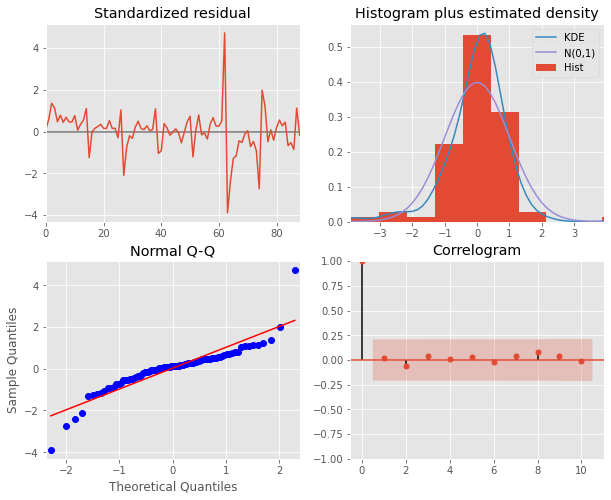

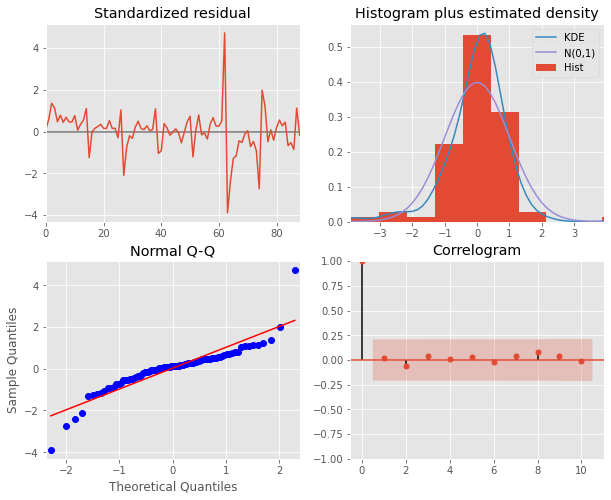

In [51]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

# your code here
model_rtrd.plot_diagnostics(figsize=(10, 8))

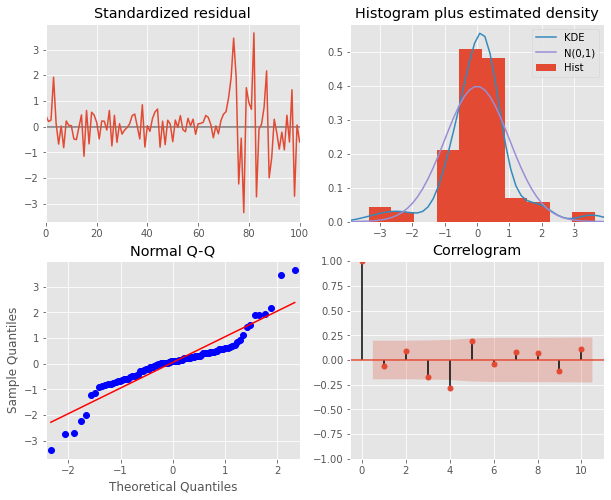

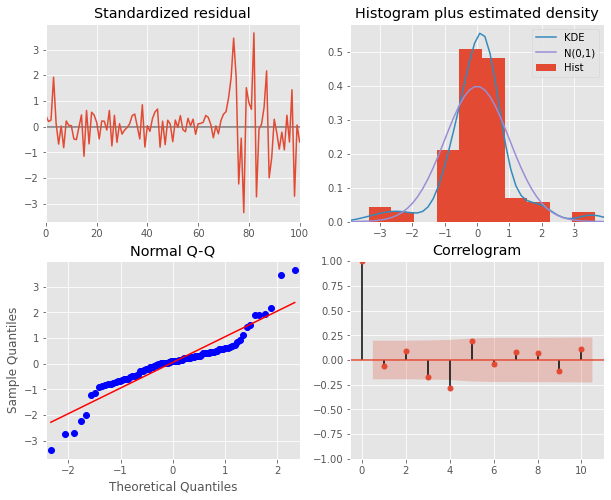

In [52]:
model_usd.plot_diagnostics(figsize=(10, 8))

Внимательно изучите код, написанный ниже. Он строит Leave One Out прогнозы. Сначала обучение идёт на `y_train`. Прогноз строится на один период вперёд. Затем одно наблюдение из `y_test` добавляется в `y_train` и та же модель обучается на новой выборке. Прогноз строится ещё на одно наблюдение вперёд. Так продолжается до тех пор, пока не кончится выборка `y`. 

In [53]:
from pmdarima import model_selection

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def loo_cv(model, y, test_size=36):
    
    y_train, y_test = y[:-test_size], y[-test_size:]

    # метод, который строит прогнозы по заданному внутри правилу
    cv = model_selection.SlidingWindowForecastCV(
        window_size=y_train.size,   # начинаем с трейновой выборки 
        step=1,                     # шаг между фолдами для обучения 
        h=1                         # на сколько шагов вперёд каждый раз строить прогноз
    )

    predicts_noIndex = model_selection.cross_val_predict(
        model, y, # идём получившейся arima_model по y 
        cv = cv,        # по правилам, заданным выше строим прогнозы 
    )
    
    return predicts_noIndex, mae(y_test, predicts_noIndex)

Используя функцию, написсанную выше, постройте прогнозы для курса доллара и оборота розничной торговли. Замерьте качество получившихся прогнозов с помощью метрики MAE. Запишите получившиеся результаты в переменные `mae_usd` и `mae_rtrd`.

In [54]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

# your code here
# loo_cv(model_usd, df['USD'])

(array([55.76402171, 59.19205806, 54.46555401, 58.06041914, 57.26886678,
        60.84244456, 58.59261276, 57.01223223, 58.76524334, 58.10528833,
        57.49542436, 55.42548528, 58.29795218, 55.79308535, 64.40803118,
        61.31391075, 64.36636075, 62.06449246, 67.98175689, 67.51898219,
        65.05656936, 67.32807516, 67.08862834, 66.3317657 , 65.45315912,
        66.10524189, 64.07812701, 65.32467611, 63.27909353, 64.06090536,
        67.14766034, 63.01216132, 65.30725259, 63.22517421, 62.59055915,
        61.0740648 ]),
 1.3861217986691086)

In [55]:
# loo_cv(model_rtrd, df['RTRD'])

(array([2308.43209654, 2312.53271196, 2360.749337  , 2399.34192363,
        2508.89058247, 2586.5360091 , 2546.01140882, 2583.61872098,
        2580.56727187, 3059.85768282, 2368.14347339, 2311.05131122,
        2475.97423483, 2456.85855619, 2512.17384312, 2552.3668993 ,
        2651.78209974, 2723.31606326, 2718.18012593, 2742.72646941,
        2721.01588214, 3256.63056477, 2530.17491296, 2459.68862085,
        2671.68382882, 2663.42812424, 2714.08141336, 2759.29456586,
        2820.45654106, 2913.61706347, 2880.37300687, 2893.55541505,
        2917.23529116, 3473.88230923, 2669.27678608, 2601.27001588]),
 18.75921820075228)

In [56]:
mae_usd = 1.3861217986691086
mae_rtrd = 18.75921820075228

Изобразите получившиеся прогнозы и исходный ряд на одной картинке. Можно попрбовать использовать для этого функцию `plot_series` из пакет `sktime`. Не забудьте установить его в своё текущее локальное окружение по аналогии с тем, как ммы это сделали для предыдущей домашней работы. 

In [57]:
# !pip install --ignore-installed sktime

     |████████████████████████████████| 5.8 MB 25.3 MB/s 
     |████████████████████████████████| 3.4 MB 107.1 MB/s 
     |████████████████████████████████| 9.5 MB 81.6 MB/s 
     |████████████████████████████████| 22.3 MB 96.0 MB/s eta 0:00:01    |████████████                    | 8.3 MB 96.0 MB/s eta 0:00:01
     |████████████████████████████████| 15.7 MB 100.8 MB/s eta 0:00:01
     |████████████████████████████████| 10.8 MB 104.6 MB/s eta 0:00:01
     |████████████████████████████████| 25.3 MB 101.5 MB/s eta 0:00:01
     |████████████████████████████████| 819 kB 78.3 MB/s eta 0:00:01
     |████████████████████████████████| 510 kB 101.1 MB/s eta 0:00:01
     |████████████████████████████████| 247 kB 107.2 MB/s eta 0:00:01
     |████████████████████████████████| 303 kB 69.4 MB/s eta 0:00:01
     |████████████████████████████████| 28.5 MB 98.2 MB/s eta 0:00:01
     |████████████████████████████████| 231 kB 103.4 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/pyt

In [59]:
df

,poiskInd_corr,RTRD,levada_IPN,USD
fielddate,,,,
2008-09-01,44.898937,1242.8,100.000000,25.269933
2008-10-01,77.752701,1277.6,73.684211,26.356378
2008-11-01,60.677571,1244.4,60.526316,27.333700
2008-12-01,50.113771,1460.1,47.368421,28.151273
2009-01-01,36.988562,1101.0,30.263158,32.492253
...,...,...,...,...
2019-10-01,35.473273,2904.6,64.473684,64.374991
2019-11-01,35.629624,2932.5,65.789474,63.867119
2019-12-01,35.525537,3472.9,68.421053,62.932538


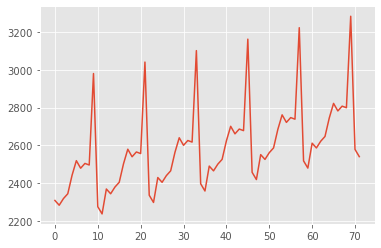

In [68]:
plt.plot(model_rtrd.predict(72))

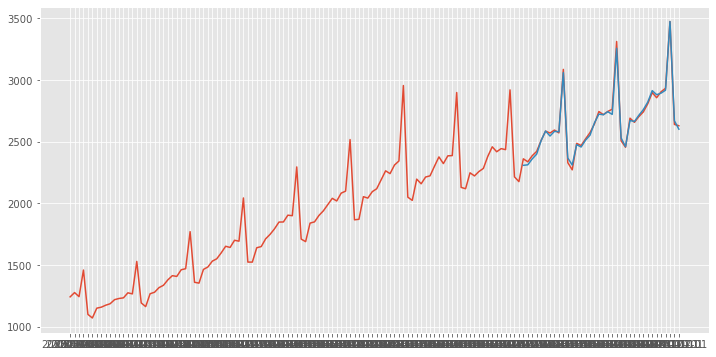

In [62]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you
# from sktime.utils.plotting import plot_series
# your code here
plt.figure(figsize=(12, 6))
plt.plot(df['RTRD'].index, df['RTRD'])
plt.plot(df["RTRD"].iloc[-36:].index, loo_cv(model_rtrd, df['RTRD'])[0])

> __ВАЖНО!!!__ Перед отправкой тетрадки в грейдер на оценивание закомментируйте код, который обучает модели. Оставьте только ответы, записанные в соотвествующие переменные. При выставлении оценки ваш код должен отрабатывать за 30 секунд. Из-за того, что модель обучается довольно долго, полноценный код процедуру тестирования не пройдёт.

# 5. ARIMA с экзогенными переменными

Теперь давайте добавим в качестве экзогенной переменной в нашу модель лаги индексов неопределённости. Если бы у нас была модель $ARMA(1,1)$ и мы бы захотели добавить в неё экзогенную переменную $x_{t-1}$, модель выглядела бы так:

$$
y_t = \mu + \beta \cdot  y_{t-1} + \alpha \cdot \varepsilon_{t-1} + \varepsilon_t + \gamma \cdot x_{t-1} 
$$

Экзогенных переменных можно добавить сколько угодно. Для этого у модели есть отдельный параметр. Он на вход принимает матрицу. Для удобства всю процедуру оценки модели завернём в функцию. Внимательно изучите, чем именно эта функция отличается от предыдущей. 

In [69]:
def loo_cv_with_index(model, y, x, test_size=36):
    
    y_train, x_train = y[:-test_size], x[:-test_size]    
    y_test, x_test = y[-test_size:], x[-test_size:]

    cv = model_selection.SlidingWindowForecastCV(
        window_size=y_train.size, 
        step=1, 
        h=1
    )

    predicts = model_selection.cross_val_predict(
        model, y,
        exogenous = np.array([x]).T,
        cv=cv
    )
    
    return predicts, mae(y_test, predicts)

Лучшую модель мы подобрали. Давайте попробуем добавить в неё в качестве экзогенной переменной наши индексы неопределённости. Это поможет нам увидеть, правда ли эти индексы улучшают качество прогнозов.

### Оборот розничной торговли

Добавим текущее значение индекса. Если качество прогноза вырасте, это означает, что текущий индекс содержит в себе информацию о том, что произошло в экономике прямо сейчас. Для прогнозирования это бесполезно, но показывает насколько сильно наш индекс может объяснить ситуацию в экономике.

> Код ниже может работать довольно долго. 

In [70]:
y = df.RTRD.values
x = df.levada_IPN.values

# predicts_levada_rtrd, mae_rtrd_2 = loo_cv_with_index(model_rtrd, y, x)

In [71]:
y = df.RTRD.values
x = df.poiskInd_corr.values

# predicts_poisk_rtrd, mae_rtrd_3 = loo_cv_with_index(model_rtrd, y, x)

In [72]:
print(f'Оригинальная модель: {mae_rtrd}')
print(f'Модель с индексом Левады: {mae_rtrd_2}')
print(f'Модель с индексом поиска: {mae_rtrd_3}')

Оригинальная модель: 18.75921820075228
Модель с индексом Левады: 17.40324631991804
Модель с индексом поиска: 21.03537048032875


Индекс Левады улучшил прогноз оборота розничной торговли. Индекс поиска ухудшил. Попробуем посмотреть, получится ли у нас предсказывать по текущему значению индекса будущее значение оборота розничной торговли.

In [73]:
y = df.RTRD.values[1:]
x = df.levada_IPN.shift(1).values[1:] # shift это сдвиг на 1 вперёд, мы же предсказываем лагом

# predicts_levada_rtrd, mae_rtrd_2 = loo_cv_with_index(model_rtrd, y, x)

In [74]:
y = df.RTRD.values[1:]
x = df.poiskInd_corr.shift(1).values[1:] # shift это сдвиг на 1 вперёд, мы же предсказываем лагом

# predicts_poisk_rtrd, mae_rtrd_3 = loo_cv_with_index(model_rtrd, y, x)

In [75]:
print(f'Оригинальная модель: {mae_rtrd}')
print(f'Модель с индексом Левады: {mae_rtrd_2}')
print(f'Модель с индексом поиска: {mae_rtrd_3}')

Оригинальная модель: 18.75921820075228
Модель с индексом Левады: 21.53266510682205
Модель с индексом поиска: 19.084777398107477


Видно, что оба индекса ухудшили прогнозы :( 

###  Курс валюты 

Проделаем такую же операцию с валютным курсом. 

In [76]:
y = df.USD.values
x = df.levada_IPN.values

# predicts_levada_usd, mae_usd_2 = loo_cv_with_index(model_usd, y, x)

In [77]:
y = df.USD.values
x = df.poiskInd_corr.values

# predicts_poisk_usd, mae_usd_3 = loo_cv_with_index(model_usd, y, x)

In [78]:
print(f'Оригинальная модель: {mae_usd}')
print(f'Модель с индексом Левады: {mae_usd_2}')
print(f'Модель с индексом поиска: {mae_usd_3}')

Оригинальная модель: 1.3861217986691086
Модель с индексом Левады: 1.3393457715076373
Модель с индексом поиска: 1.366235301536545


Видго, что оба индекса содержат информацию о том, какие значения курс принял прямо сейчас. Попробуем посмотреть, можно ли прогнозировать курс с помощью запаздывания лучше, чем обычной ARIMA. 

In [79]:
y = df.USD.values[1:]
x = df.levada_IPN.shift(1).values[1:] # shift это сдвиг на 1 вперёд, мы же предсказываем лагом

# predicts_levada_usd, mae_usd_2 = loo_cv_with_index(model_usd, y, x)

In [80]:
y = df.USD.values[1:]
x = df.poiskInd_corr.shift(1).values[1:] # shift это сдвиг на 1 вперёд, мы же предсказываем лагом

# predicts_poisk_usd, mae_usd_3 = loo_cv_with_index(model_usd, y, x)

In [81]:
print(f'Оригинальная модель: {mae_usd}')
print(f'Модель с индексом Левады: {mae_usd_2}')
print(f'Модель с индексом поиска: {mae_usd_3}')

Оригинальная модель: 1.3861217986691086
Модель с индексом Левады: 1.3870816021784633
Модель с индексом поиска: 1.3590031426519782


Видно, что индекс поиска улучшил прогнозы. Индекс Левады не привёл к улучшению. 

__Выводы:__ индексы поиска и Левады содержут информацию о том, что в данный момент происходит в экономике. Их текущее значение помогает предсказать, что происходит прямо сейчас в экономике. На практике это бесполезно. Мы хотим по вчерашнему значению индекса спрогнозировать, что произойдет завтра. Видно, что это можно сделать для курса доллара с помощью индекса поиска.

Обратите внимание, что данные у нас месячные. Если бы частота данных была бы повыше, эффект от добавления индексов в модели мог бы быть сильнее. Но это требует отдельного исследования :) 

Попробуйте, по аналогии с тем, что было сделано выше, добавить в модель в качестве экзогенных переменных сразу оба индекса. Насколько сильно это улучшает прогноз? 

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

> __ВАЖНО!!!__ Перед отправкой тетрадки в грейдер на оценивание закомментируйте код, который обучает модели. Оставьте только ответы, записанные в соотвествующие переменные. При выставлении оценки ваш код должен отрабатывать за 30 секунд. Из-за того, что модель обучается довольно долго, полноценный код процедуру тестирования не пройдёт.

# Бонусный трэк:

- Попробуйте взять в качестве дополнительных экзогенных переменных сразу же и индекс поиска и индекс Левада-центра. 
- Выше мы сказали, что у валютного курса не самая стабильная дисперсия. Соберите пайплайн, в котором первым шагом метод Бокса-Кокса будет стабилизировать дисперсию. Обучите обе модели и посмотрите что происходит с качеством прогнозов. 
- По картинкам для диагностики модели видно, что в данных есть выброс. Можно попробовать изолировать его с помощью экзогенной дамми-переменной, если хочется добиться идеального выполнения предпосылок. 
- Если вас заинтересовали индексы неопределённости, можно посмотреть [статью автора курса про такие индексы бывают с кучей ссылок и кодом](https://github.com/FUlyankin/uncertainty_index)

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you